# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

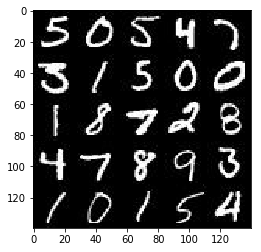

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

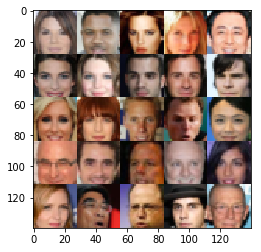

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name = 'learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse = reuse):       
        
        #Input layer 28x28x3        
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2,training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3,training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 3x3x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)

        return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    
    with tf.variable_scope('generator',reuse = not is_train):
        
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        # 4x4x512
        
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
       
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)  
        
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real,input_z,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(input_real,input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images.reshape(batch_size, data_shape [1], data_shape[2],data_shape[3])
                
                batch_images = batch_images * 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3],data_image_mode)

        
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.7515... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 0.0251... Generator Loss: 3.9010
Epoch 1/2... Discriminator Loss: 0.2132... Generator Loss: 6.5816
Epoch 1/2... Discriminator Loss: 0.8022... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 6.0389
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 6.6573
Epoch 1/2... Discriminator Loss: 0.4029... Generator Loss: 3.3619
Epoch 1/2... Discriminator Loss: 2.4687... Generator Loss: 5.1836
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.3637


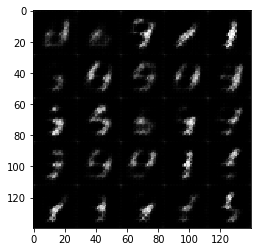

Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.4116
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.6998... Generator Loss: 3.8273
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 2.0579
Epoch 1/2... Discriminator Loss: 1.6155... Generator Loss: 2.5113
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.4459


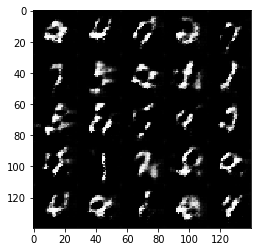

Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 0.6803... Generator Loss: 1.3223
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 2.3129
Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 1.7802
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.2803
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 2.5549
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.3264


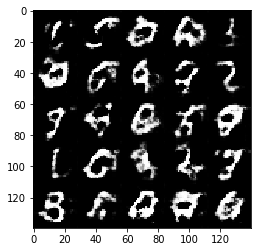

Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 0.9058
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.3479
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 1.3535


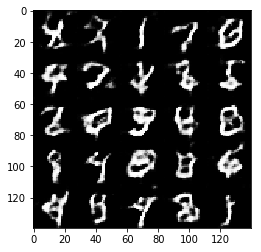

Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 1.8038
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.6138
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.5226
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 0.7906... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.0782


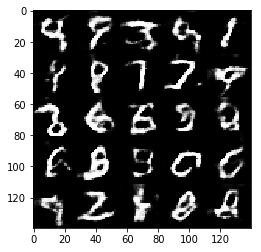

Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 1.4666
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.0754
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 0.8871


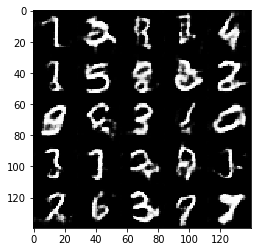

Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.5146
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.5861
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.2476
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 1.9622
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.5537
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.4954
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 1.5334
Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 0.7710


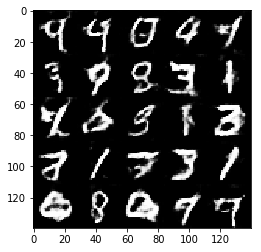

Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.5738
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.1743
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 1.8006
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 1.6922
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 2.4896


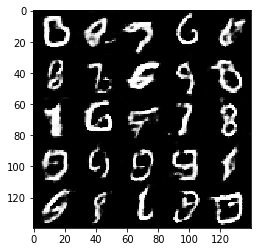

Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.2776
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.3723
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 1.2690


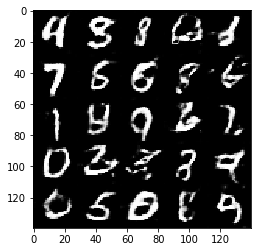

Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.6340


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 16.9573
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 8.8857
Epoch 1/1... Discriminator Loss: 0.0625... Generator Loss: 3.5499
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 5.2607
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.0713
Epoch 1/1... Discriminator Loss: 3.4199... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 5.0221
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 1.4751


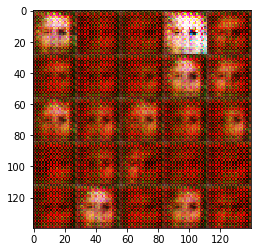

Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 2.9730
Epoch 1/1... Discriminator Loss: 0.2538... Generator Loss: 2.2790
Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 5.2666
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 4.1314... Generator Loss: 0.0251
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 2.2934
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 2.1529
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.9542... Generator Loss: 0.2551
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6725


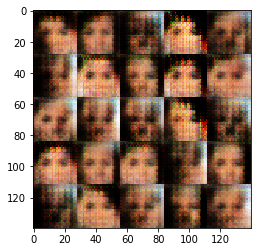

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.9791... Generator Loss: 0.1927
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 1.8309... Generator Loss: 0.2794
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 2.4329
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.3531


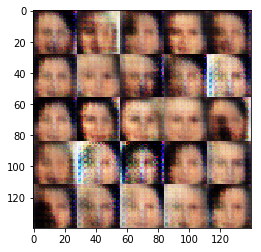

Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.3457
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8415


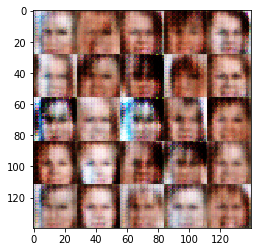

Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.2580
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7992


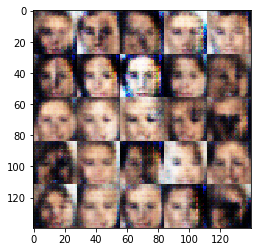

Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.6894
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 4.2168... Generator Loss: 6.2403
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.1678


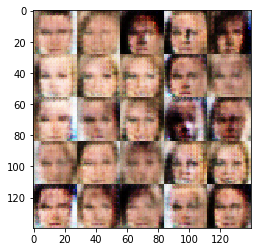

Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 2.7857... Generator Loss: 3.5842
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.6950
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 2.2799... Generator Loss: 3.0610


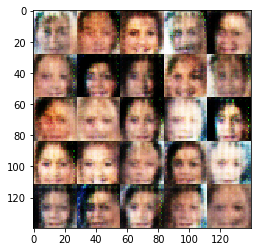

Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 2.3426
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.7278
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.6137


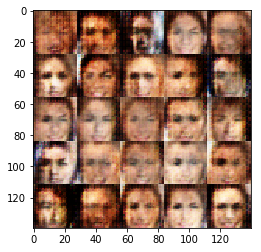

Epoch 1/1... Discriminator Loss: 2.0293... Generator Loss: 0.2229
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.3026
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.8965
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.3706
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 1.2080


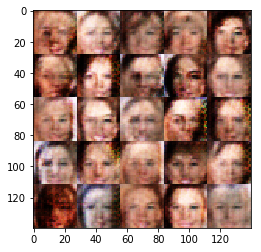

Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.4947
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.0104


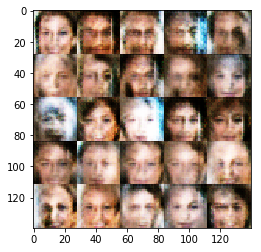

Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 2.0042
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.6617
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 0.8465


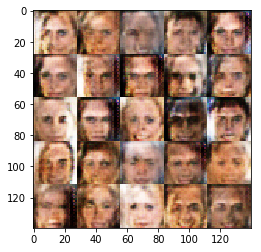

Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.8194
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.8207
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 1.5776
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.9520


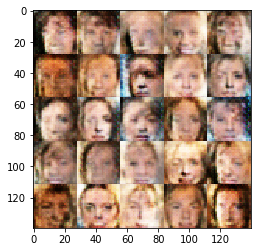

Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 1.6592
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.0104


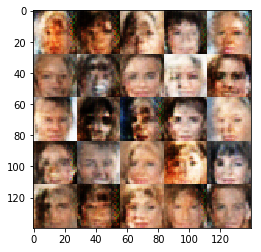

Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 2.4044
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.0119


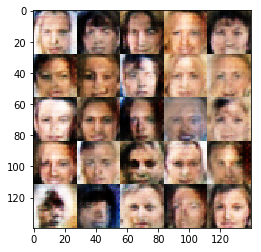

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 1.6666
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.8983


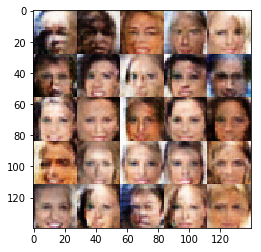

Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.0079


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.